<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2020chuo/007transfer_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Note: 公式チュートリアルの転移学習が元ファイル
- File:${HOME}/study/2020pytorch_tutorials.git/_build/html/beginner/transfer_learning_tutorial.html

In [0]:
%matplotlib inline


# Transfer Learning for Computer Vision Tutorial

**Author**: `Sasank Chilamkurthy` <https://chsasank.github.io>

<!--In this tutorial, you will learn how to train a convolutional neural network for image classification using transfer learning. 
You can read more about the transfer learning at `cs231n notes` <https://cs231n.github.io/transfer-learning/>
-->

このチュートリアルでは 転移学習による画像分類の畳み込みニューラルネットワークの訓練を実習します。
転移学習の詳細については https://cs231n.github.io/transfer-learning/ を参照して下さい。

<!--Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.
-->

引用すると：
    実際には、十分なサイズのデータセットを持つことは比較的まれであるため，ゼロから畳み込みネットワーク全体を（ランダム初期化で）トレーニングする人はほとんどいません。代わりに 非常に大きなデータセット（たとえば、1000 のカテゴリで 120万 の画像を含む ImageNet データセット）でCNN を事前訓練し その後 CNN を目標とする課題の初期値として再学習，または結合係数を固定した機能抽出器として使用します。

具体的に以下のような 2 つの転移学習のシナリオがあります:
<!--These two major transfer learning scenarios look as follows:

- **Finetuning the convnet**: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.
-->

- **CNN のファインチューニング**：ランダムな初期化の代わりに imagenet の 1000 分類データセットで事前訓練した学習済ネットワークでネットワークを初期化する。その後の訓練は通常どおり
- **固定特徴抽出器としての CNN**：最終全結合層を除くネットワークの重み係数を固定化する。最終全結合層は乱数で初期した層で置換し，この最終層のみを訓練する

In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Load Data

<!--We will use torchvision and torch.utils.data packages for loading the data.

The problem we're going to solve today is to train a model to classify **ants** and **bees**. 
We have about 120 training images each for ants and bees. 
There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. 
Since we are using transfer learning, we should be able to generalize reasonably well.
-->

データをロードするために `torchvision` と `torch.utils.data` パッケージを使用します。

今，解決しようとしている問題は、**蟻** と **蜂** とを分類するモデルを訓練することです。
アリとハチのそれぞれについて約 120 の訓練画像があります。
各クラスには 75 個の検証画像があります。通常ゼロから訓練した場合には，一般化するには小さな過ぎるデータセットサイズです。
転移学習を使用すると，十分に合理的に一般化できるはずです。

This dataset is a very small subset of imagenet.

<div class="alert-info">
注意:
</div>

Download the data from `here` https://download.pytorch.org/tutorial/hymenoptera_data.zip and extract it to the current directory.


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
#dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=0)
#                                             shuffle=True, num_workers=4)
               
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 画像の表示

データ拡張を理解するために，何枚かの画像を表示させてみます。
<!--
### Visualize a few images

Let's visualize a few training images so as to understand the data augmentations.
-->


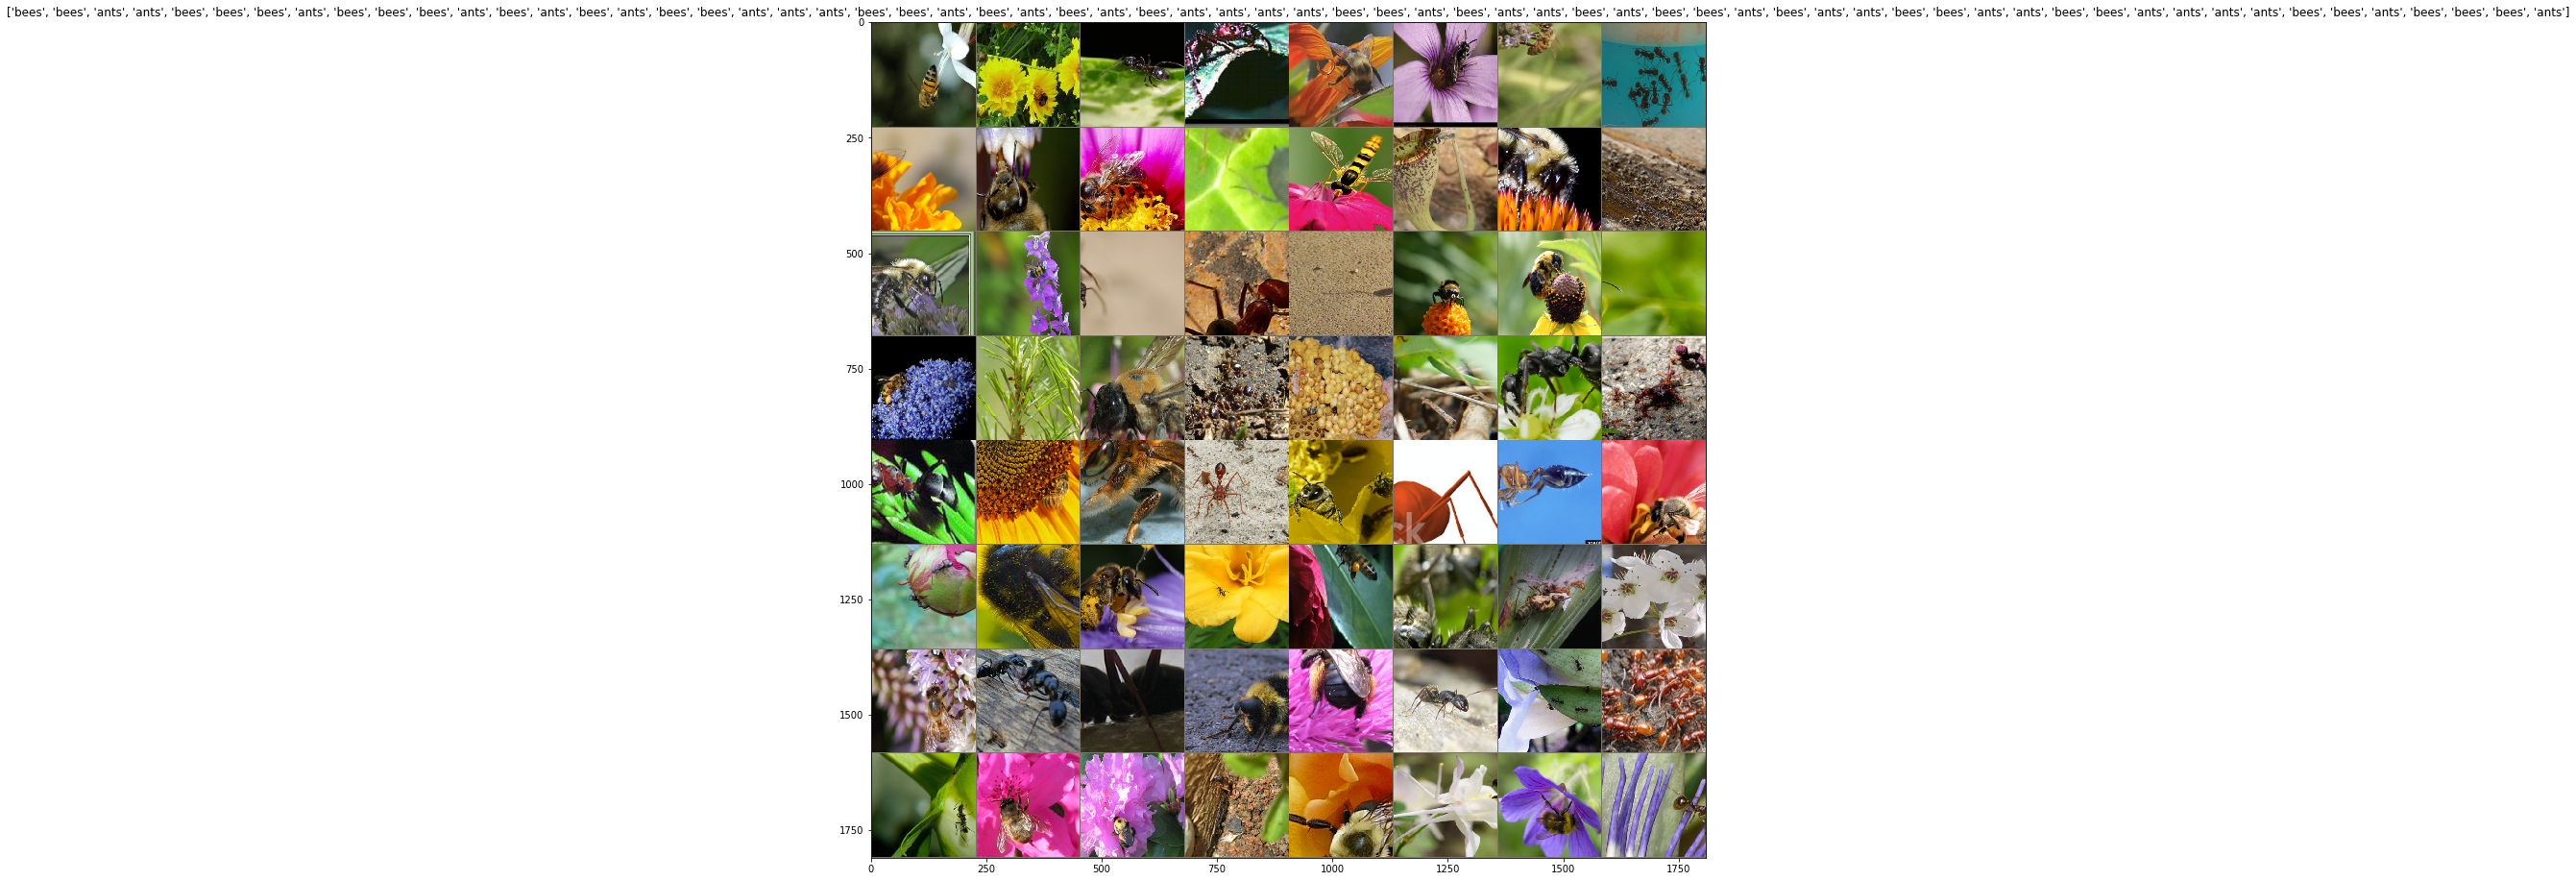

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # 色チャンネルの順番が異なるので入れ替え
                                            # numpy では (y, x, c) だが pytorch では (y, x, c)
    mean = np.array([0.485, 0.456, 0.406])  # 平均値
    std = np.array([0.229, 0.224, 0.225])   # 標準偏差
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(16,16))  # added by Shin ASakawa
imshow(out, title=[class_names[x] for x in classes])

<!--# Training the model-->

# モデルの訓練

モデルを訓練するための一般的な関数を作成します。
<!--
Now, let's write a general function to train a model. Here, we will illustrate:
-->

- 学習係数のスケジューリング
- 最良モデルの保存

<!--
-  Scheduling the learning rate
-  Saving the best model
-->

<!--In the following, parameter ``scheduler`` is an LR scheduler object from ``torch.optim.lr_scheduler``.-->

以下 `torch.optim.lr_scheduler` から継承したパラメータ `schduler` は学習係数 `LR` のスケジューラです。  



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images


In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
#dir(models.resnet)

<!--
### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.
-->

### 訓練と評価
CPU で実行すると 15-25 分かかります。GPU なら 1 分以内です。

In [0]:
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: 

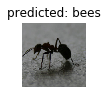

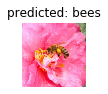

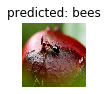

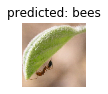

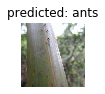

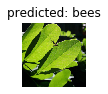

In [0]:
visualize_model(model_ft)

In [0]:
# モデルを print するとモデルの構造が表示されます
# print(model_ft)

<!--
# ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set ``requires_grad == False`` to freeze the parameters so that the gradients are not computed in ``backward()``.

You can read more about this in the documentation `here` https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>.
-->

# 固定特徴抽出器としての畳込みネットワーク

ここでは，最終層を除くすべてのネットワークをフリーズする必要があります。 勾配が `backward()` で計算されないように，パラメーターを凍結するには `requires_grad == False` を設定する必要があります。

この詳細については [こちらのドキュメント](https://pytorch.org/docs/notes/autograd.html#exexcept-subgraphs-from-backward) を参照してください。

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 訓練と評価

<!--
On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the network. However, forward does need to be computed.
-->

CPU 環境では前のシナリオと比較して約半分の時間で済みます。
ほとんどの部分のネットワークで勾配を計算する必要がないためです。 
ただし、フォワードを計算する必要があります。


In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6479 Acc: 0.6270
val Loss: 0.5240 Acc: 0.7647

Epoch 1/24
----------
train Loss: 0.5975 Acc: 0.6680
val Loss: 0.5012 Acc: 0.7386

Epoch 2/24
----------
train Loss: 0.5140 Acc: 0.7664
val Loss: 0.4045 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.4804 Acc: 0.8033
val Loss: 0.3633 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4065 Acc: 0.8566
val Loss: 0.3215 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.3975 Acc: 0.8361
val Loss: 0.2931 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.3076 Acc: 0.9221
val Loss: 0.2664 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.2852 Acc: 0.9221
val Loss: 0.2657 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3235 Acc: 0.8811
val Loss: 0.2649 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2971 Acc: 0.9098
val Loss: 0.2631 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3083 Acc: 0.8975
val Loss: 0.2621 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2838 Acc: 0.8975
val Loss: 0.2626 Acc: 0.9281

Ep

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Further Learning

If you would like to learn more about the applications of transfer learning, checkout our `Quantized Transfer Learning for Computer Vision Tutorial` <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning.html>. 


